## Import Libraries

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

## Dataset

In [5]:
df = pd.read_csv('questions_answers.csv', sep='\t')

### Explore the dataset

In [6]:
df.head()

,question,reponse
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [7]:
df.shape

(3725, 2)

## Data Preprocessing

In [8]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['reponse tokens']=df['reponse'].apply(lambda x:len(x.split()))

In [9]:
df

,question,reponse,question tokens,reponse tokens
0,"hi, how are you doing?",i'm fine. how about yourself?,5,5
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,5,6
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,6,7
3,no problem. so how have you been?,i've been great. what about you?,7,6
4,i've been great. what about you?,i've been good. i'm in school right now.,6,8
...,...,...,...,...
3720,that's a good question. maybe it's not old age.,are you right-handed?,9,3
3721,are you right-handed?,yes. all my life.,3,4
3722,yes. all my life.,you're wearing out your right hand. stop using...,4,11
3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.,11,10


### Plot the number of tokens in each sentence

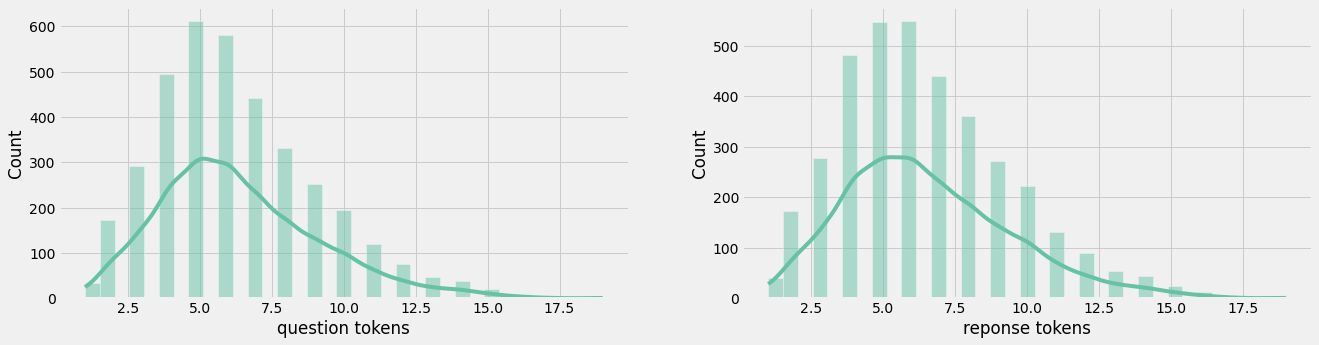

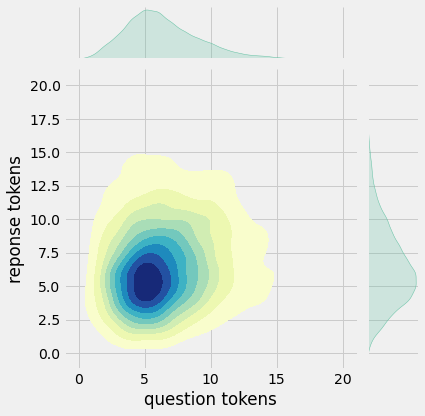

In [10]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['reponse tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='reponse tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

### Clean the text

In [11]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

In [12]:
# Dropping Unnecessary Columns
df.drop(columns=['reponse tokens','question tokens'],axis=1,inplace=True)
# Cleaning Text Data
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['reponse'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['reponse'].apply(clean_text)+' <end>'

df.head(10)

,question,reponse,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [13]:
# Counting Tokens in Encoder, Decoder Inputs & Decoder Targets
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))

### Visualizes token distributions in questions and responses, and their density relationship.

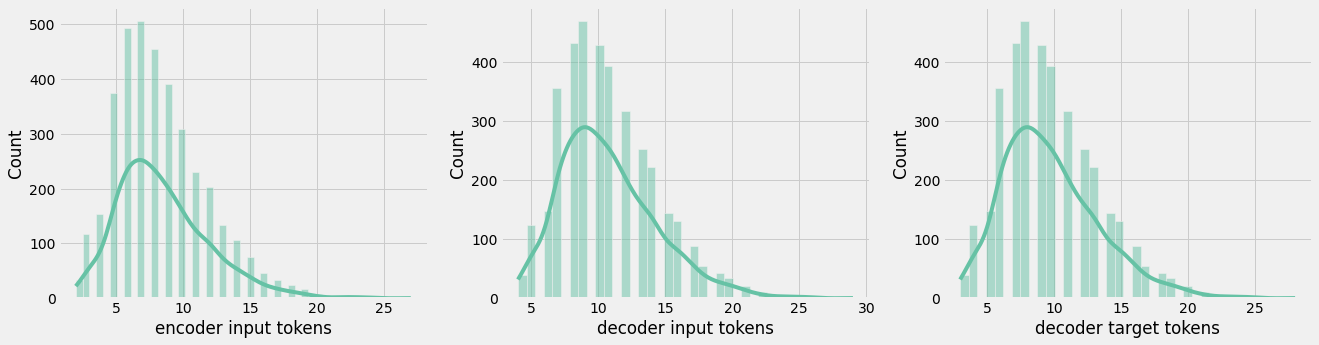

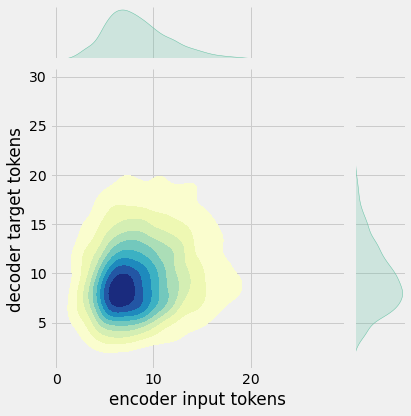

In [14]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [15]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','reponse','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


In [16]:
# Model Parameters & Hyperparameters with LSTM
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']

In [17]:
df.head(10)

,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


## Tokenization

### Configures text vectorization, adapting it to both inputs and targets, and displays the updated vocabulary size and top tokens.

In [18]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


### Converts text to IDs and back, showcasing shapes of model inputs and outputs.

In [19]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: Qui sont les personnes qui travaillent la terre ?')
print(f'Question to tokens: {sequences2ids("Qui sont les personnes qui travaillent la terre ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: Qui sont les personnes qui travaillent la terre ?
Question to tokens: [1 1 1 1 1 1 1 1 7 0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [20]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


### Prepares training and validation datasets, details data batching and shapes.

In [21]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


## Build Models

### Build Encoder

### Defines an Encoder class for a Seq2Seq model, embedding inputs and processing them through LSTM.

In [22]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[-0.12988241, -0.12375345, -0.05631969, ..., -0.05488194,
          0.1963632 , -0.00320365],
        [-0.00576419, -0.02570225,  0.1954893 , ..., -0.12818106,
          0.27123162, -0.12193924],
        [-0.15209688,  0.17203379, -0.01812964, ..., -0.05556075,
          0.0824681 ,  0.09241733],
        ...,
        [-0.03896183,  0.19642253, -0.29343554, ..., -0.20490964,
         -0.18342559, -0.04303272],
        [ 0.04905035,  0.21157108, -0.13912287, ..., -0.21040344,
         -0.21072322, -0.03454934],
        [-0.03229577, -0.04964048, -0.05420135, ..., -0.1670446 ,
          0.06762885, -0.22299078]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[-0.24526425, -0.2573132 , -0.09990039, ..., -0.10961744,
          0.3241631 , -0.00497907],
        [-0.01048842, -0.05714052,  0.3400551 , ..., -0.24444859,
          0.46408492, -0.186231  ],
        [-0.31429097,  0.36716485, -0.03253692,

### Build Decoder

### Implements a Decoder class with embedding, LSTM, and dense layers, integrating encoder states for Seq2Seq processing.

In [23]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[2.75071652e-04, 3.98164906e-04, 1.42119519e-04, ...,
         3.68301953e-05, 4.65400168e-04, 2.79785090e-05],
        [8.81082087e-05, 3.06368107e-04, 1.13396230e-03, ...,
         7.23690246e-05, 1.06223364e-04, 3.24117173e-05],
        [7.51045154e-05, 3.75108299e-04, 1.03604503e-03, ...,
         2.30654405e-04, 4.88584861e-04, 1.15102943e-04],
        ...,
        [8.92975586e-05, 1.82393531e-04, 7.15812930e-05, ...,
         4.78647329e-04, 3.40600428e-03, 4.38021932e-04],
        [8.92975586e-05, 1.82393531e-04, 7.15812930e-05, ...,
         4.78647329e-04, 3.40600428e-03, 4.38021932e-04],
        [8.92975586e-05, 1.82393531e-04, 7.15812930e-05, ...,
         4.78647329e-04, 3.40600428e-03, 4.38021932e-04]]], dtype=float32)>

### Build Training Model

### Integrates Encoder and Decoder into a ChatBotTrainer model, including custom training, testing, and metric evaluation logic.

In [24]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

### Configures and compiles the ChatBotTrainer model for training, setting up loss function, optimizer, and metrics.

In [22]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[8.56409315e-04, 4.12130757e-05, 3.54610238e-04, ...,
         3.26836511e-04, 3.31033079e-05, 4.98468362e-05],
        [1.47679064e-03, 3.29113682e-04, 8.60135246e-04, ...,
         7.08459062e-04, 1.36451717e-05, 1.19633391e-04],
        [1.20405911e-03, 2.66798050e-03, 2.26656746e-04, ...,
         3.78452503e-04, 1.55641974e-05, 3.24626046e-04],
        ...,
        [6.52578674e-05, 1.05030827e-04, 5.36916377e-05, ...,
         1.11544548e-04, 1.63565437e-05, 1.89776329e-05],
        [6.52578674e-05, 1.05030827e-04, 5.36916377e-05, ...,
         1.11544548e-04, 1.63565455e-05, 1.89776329e-05],
        [6.52578674e-05, 1.05030827e-04, 5.36916377e-05, ...,
         1.11544548e-04, 1.63565437e-05, 1.89776329e-05]],

       [[1.18872628e-03, 6.17087353e-05, 2.82912806e-04, ...,
         2.15829714e-04, 2.41377638e-04, 7.80222181e-05],
        [1.78643502e-03, 3.26705194e-04, 3.34411336e-04, ...,
         1.06065301e-03, 6

## Train Model

In [23]:
history=model.fit(
    train_data,
    epochs=150,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/150


23/23 [==============================] - ETA: 0s - loss: 1.6590 - accuracy: 0.2198
Epoch 1: val_loss improved from inf to 1.27692, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 61s 2s/step - loss: 1.6503 - accuracy: 0.2223 - val_loss: 1.2769 - val_accuracy: 0.2890
Epoch 2/150
23/23 [==============================] - ETA: 0s - loss: 1.2398 - accuracy: 0.3098
Epoch 2: val_loss improved from 1.27692 to 1.13045, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 46s 2s/step - loss: 1.2359 - accuracy: 0.3102 - val_loss: 1.1305 - val_accuracy: 0.3319
Epoch 3/150
23/23 [==============================] - ETA: 0s - loss: 1.1090 - accuracy: 0.3397
Epoch 3: val_loss improved from 1.13045 to 0.97255, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 70s 3s/step - loss: 1.1085 - accuracy: 0.3402 - val_loss: 0.9726 - val_accuracy: 0.3518
Epoch 4/150
23/23 [==============================] - ETA: 0s - loss: 1.0246 - accuracy: 0.3562
Epoch 4: val_loss improved from 0.97255 to 0.85672, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 76s 3s/step - loss: 1.0237 - accuracy: 0.3565 - val_loss: 0.8567 - val_accuracy: 0.3997
Epoch 5/150
23/23 [==============================] - ETA: 0s - loss: 0.9679 - accuracy: 0.3696
Epoch 5: val_loss improved from 0.85672 to 0.83682, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 89s 4s/step - loss: 0.9664 - accuracy: 0.3700 - val_loss: 0.8368 - val_accuracy: 0.3675
Epoch 6/150
23/23 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.3822
Epoch 6: val_loss did not improve from 0.83682
23/23 [==============================] - 72s 3s/step - loss: 0.9233 - accuracy: 0.3824 - val_loss: 0.8838 - val_accuracy: 0.3949
Epoch 7/150
23/23 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.3915
Epoch 7: val_loss did not improve from 0.83682
23/23 [==============================] - 70s 3s/step - loss: 0.8795 - accuracy: 0.3920 - val_loss: 0.8697 - val_accuracy: 0.3906
Epoch 8/150
23/23 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.4021
Epoch 8: val_loss improved from 0.83682 to 0.82586, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 119s 5s/step - loss: 0.8445 - accuracy: 0.4028 - val_loss: 0.8259 - val_accuracy: 0.3949
Epoch 9/150
23/23 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.4121
Epoch 9: val_loss did not improve from 0.82586
23/23 [==============================] - 50s 2s/step - loss: 0.8174 - accuracy: 0.4118 - val_loss: 0.8864 - val_accuracy: 0.4157
Epoch 10/150
23/23 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.4177
Epoch 10: val_loss improved from 0.82586 to 0.78255, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 85s 4s/step - loss: 0.7939 - accuracy: 0.4179 - val_loss: 0.7825 - val_accuracy: 0.4562
Epoch 11/150
23/23 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.4235
Epoch 11: val_loss did not improve from 0.78255
23/23 [==============================] - 75s 3s/step - loss: 0.7725 - accuracy: 0.4224 - val_loss: 0.8237 - val_accuracy: 0.4381
Epoch 12/150
23/23 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.4376
Epoch 12: val_loss improved from 0.78255 to 0.77287, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 109s 5s/step - loss: 0.7477 - accuracy: 0.4372 - val_loss: 0.7729 - val_accuracy: 0.4561
Epoch 13/150
23/23 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.4451
Epoch 13: val_loss improved from 0.77287 to 0.67675, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 131s 6s/step - loss: 0.7314 - accuracy: 0.4456 - val_loss: 0.6768 - val_accuracy: 0.5014
Epoch 14/150
23/23 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.4545
Epoch 14: val_loss did not improve from 0.67675
23/23 [==============================] - 84s 4s/step - loss: 0.7090 - accuracy: 0.4546 - val_loss: 0.7904 - val_accuracy: 0.4435
Epoch 15/150
23/23 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4627
Epoch 15: val_loss did not improve from 0.67675
23/23 [==============================] - 83s 4s/step - loss: 0.6955 - accuracy: 0.4627 - val_loss: 0.7010 - val_accuracy: 0.4779
Epoch 16/150
23/23 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.4680
Epoch 16: val_loss did not improve from 0.67675
23/23 [==============================] - 74s 3s/step - loss: 0.6808 - accuracy: 0.4668 - val_loss: 0.7222 - val_accuracy: 0.4130
Epoch 17/150
23/23 [==============================]

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 111s 5s/step - loss: 0.6697 - accuracy: 0.4720 - val_loss: 0.6479 - val_accuracy: 0.5081
Epoch 18/150
23/23 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.4775
Epoch 18: val_loss did not improve from 0.64789
23/23 [==============================] - 77s 3s/step - loss: 0.6542 - accuracy: 0.4767 - val_loss: 0.6790 - val_accuracy: 0.4693
Epoch 19/150
23/23 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.4839
Epoch 19: val_loss did not improve from 0.64789
23/23 [==============================] - 104s 5s/step - loss: 0.6366 - accuracy: 0.4843 - val_loss: 0.7412 - val_accuracy: 0.4791
Epoch 20/150
23/23 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.4906
Epoch 20: val_loss improved from 0.64789 to 0.60454, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 130s 6s/step - loss: 0.6261 - accuracy: 0.4903 - val_loss: 0.6045 - val_accuracy: 0.4986
Epoch 21/150
23/23 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.4952
Epoch 21: val_loss improved from 0.60454 to 0.56398, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 142s 6s/step - loss: 0.6253 - accuracy: 0.4936 - val_loss: 0.5640 - val_accuracy: 0.5376
Epoch 22/150
23/23 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.5018
Epoch 22: val_loss did not improve from 0.56398
23/23 [==============================] - 94s 4s/step - loss: 0.6136 - accuracy: 0.5009 - val_loss: 0.7449 - val_accuracy: 0.4628
Epoch 23/150
23/23 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.5093
Epoch 23: val_loss did not improve from 0.56398
23/23 [==============================] - 77s 3s/step - loss: 0.6023 - accuracy: 0.5084 - val_loss: 0.6892 - val_accuracy: 0.5261
Epoch 24/150
23/23 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.5145
Epoch 24: val_loss did not improve from 0.56398
23/23 [==============================] - 94s 4s/step - loss: 0.5900 - accuracy: 0.5141 - val_loss: 0.6516 - val_accuracy: 0.5100
Epoch 25/150
23/23 [==============================]

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 57s 3s/step - loss: 0.5436 - accuracy: 0.5418 - val_loss: 0.4950 - val_accuracy: 0.5827
Epoch 31/150
23/23 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.5460
Epoch 31: val_loss did not improve from 0.49501
23/23 [==============================] - 35s 2s/step - loss: 0.5375 - accuracy: 0.5450 - val_loss: 0.5257 - val_accuracy: 0.5694
Epoch 32/150
23/23 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.5495
Epoch 32: val_loss did not improve from 0.49501
23/23 [==============================] - 35s 2s/step - loss: 0.5338 - accuracy: 0.5480 - val_loss: 0.6391 - val_accuracy: 0.5432
Epoch 33/150
23/23 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.5479
Epoch 33: val_loss did not improve from 0.49501
23/23 [==============================] - 36s 2s/step - loss: 0.5257 - accuracy: 0.5468 - val_loss: 0.5677 - val_accuracy: 0.5486
Epoch 34/150
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 55s 2s/step - loss: 0.5240 - accuracy: 0.5532 - val_loss: 0.4873 - val_accuracy: 0.5868
Epoch 35/150
23/23 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.5603
Epoch 35: val_loss did not improve from 0.48726
23/23 [==============================] - 31s 1s/step - loss: 0.5139 - accuracy: 0.5603 - val_loss: 0.6008 - val_accuracy: 0.5120
Epoch 36/150
23/23 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.5625
Epoch 36: val_loss did not improve from 0.48726
23/23 [==============================] - 30s 1s/step - loss: 0.5092 - accuracy: 0.5613 - val_loss: 0.5936 - val_accuracy: 0.5489
Epoch 37/150
23/23 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.5631
Epoch 37: val_loss did not improve from 0.48726
23/23 [==============================] - 30s 1s/step - loss: 0.5059 - accuracy: 0.5620 - val_loss: 0.5379 - val_accuracy: 0.5596
Epoch 38/150
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 52s 2s/step - loss: 0.4220 - accuracy: 0.6220 - val_loss: 0.4383 - val_accuracy: 0.6035
Epoch 58/150
23/23 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.6168
Epoch 58: val_loss did not improve from 0.43829
23/23 [==============================] - 34s 1s/step - loss: 0.4237 - accuracy: 0.6173 - val_loss: 0.5055 - val_accuracy: 0.5891
Epoch 59/150
23/23 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.6188
Epoch 59: val_loss did not improve from 0.43829
23/23 [==============================] - 34s 1s/step - loss: 0.4223 - accuracy: 0.6176 - val_loss: 0.5205 - val_accuracy: 0.6104
Epoch 60/150
23/23 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.6221
Epoch 60: val_loss did not improve from 0.43829
23/23 [==============================] - 34s 2s/step - loss: 0.4167 - accuracy: 0.6225 - val_loss: 0.4718 - val_accuracy: 0.6411
Epoch 61/150
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 55s 2s/step - loss: 0.4022 - accuracy: 0.6301 - val_loss: 0.3821 - val_accuracy: 0.6628
Epoch 67/150
23/23 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.6311
Epoch 67: val_loss did not improve from 0.38214
23/23 [==============================] - 30s 1s/step - loss: 0.4026 - accuracy: 0.6306 - val_loss: 0.4726 - val_accuracy: 0.6027
Epoch 68/150
23/23 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.6346
Epoch 68: val_loss did not improve from 0.38214
23/23 [==============================] - 33s 1s/step - loss: 0.4028 - accuracy: 0.6337 - val_loss: 0.5008 - val_accuracy: 0.5890
Epoch 69/150
23/23 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.6364
Epoch 69: val_loss did not improve from 0.38214
23/23 [==============================] - 36s 2s/step - loss: 0.3988 - accuracy: 0.6364 - val_loss: 0.4943 - val_accuracy: 0.6122
Epoch 70/150
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 52s 2s/step - loss: 0.3864 - accuracy: 0.6426 - val_loss: 0.3693 - val_accuracy: 0.6648
Epoch 76/150
23/23 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.6454
Epoch 76: val_loss did not improve from 0.36929
23/23 [==============================] - 38s 2s/step - loss: 0.3826 - accuracy: 0.6453 - val_loss: 0.5087 - val_accuracy: 0.6201
Epoch 77/150
23/23 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.6437
Epoch 77: val_loss did not improve from 0.36929
23/23 [==============================] - 39s 2s/step - loss: 0.3852 - accuracy: 0.6427 - val_loss: 0.4748 - val_accuracy: 0.6079
Epoch 78/150
23/23 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.6505
Epoch 78: val_loss did not improve from 0.36929
23/23 [==============================] - 38s 2s/step - loss: 0.3829 - accuracy: 0.6500 - val_loss: 0.4511 - val_accuracy: 0.6207
Epoch 79/150
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 59s 3s/step - loss: 0.3427 - accuracy: 0.6711 - val_loss: 0.3650 - val_accuracy: 0.6672
Epoch 106/150
23/23 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.6747
Epoch 106: val_loss did not improve from 0.36500
23/23 [==============================] - 48s 2s/step - loss: 0.3479 - accuracy: 0.6743 - val_loss: 0.4684 - val_accuracy: 0.6303
Epoch 107/150
23/23 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.6726
Epoch 107: val_loss did not improve from 0.36500
23/23 [==============================] - 48s 2s/step - loss: 0.3458 - accuracy: 0.6729 - val_loss: 0.4951 - val_accuracy: 0.6419
Epoch 108/150
23/23 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.6750
Epoch 108: val_loss did not improve from 0.36500
23/23 [==============================] - 48s 2s/step - loss: 0.3451 - accuracy: 0.6748 - val_loss: 0.4738 - val_accuracy: 0.6446
Epoch 109/150
23/23 [=========================

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 68s 3s/step - loss: 0.3458 - accuracy: 0.6764 - val_loss: 0.3629 - val_accuracy: 0.6849
Epoch 110/150
23/23 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.6813
Epoch 110: val_loss did not improve from 0.36294
23/23 [==============================] - 41s 2s/step - loss: 0.3384 - accuracy: 0.6809 - val_loss: 0.4927 - val_accuracy: 0.6158
Epoch 111/150
23/23 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.6748
Epoch 111: val_loss did not improve from 0.36294
23/23 [==============================] - 41s 2s/step - loss: 0.3398 - accuracy: 0.6756 - val_loss: 0.4309 - val_accuracy: 0.6381
Epoch 112/150
23/23 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.6765
Epoch 112: val_loss improved from 0.36294 to 0.34279, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 61s 3s/step - loss: 0.3400 - accuracy: 0.6763 - val_loss: 0.3428 - val_accuracy: 0.7023
Epoch 113/150
23/23 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.6766
Epoch 113: val_loss did not improve from 0.34279
23/23 [==============================] - 40s 2s/step - loss: 0.3401 - accuracy: 0.6766 - val_loss: 0.5099 - val_accuracy: 0.6235
Epoch 114/150
23/23 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.6797
Epoch 114: val_loss did not improve from 0.34279
23/23 [==============================] - 44s 2s/step - loss: 0.3404 - accuracy: 0.6795 - val_loss: 0.5260 - val_accuracy: 0.6184
Epoch 115/150
23/23 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.6806
Epoch 115: val_loss did not improve from 0.34279
23/23 [==============================] - 42s 2s/step - loss: 0.3362 - accuracy: 0.6809 - val_loss: 0.4746 - val_accuracy: 0.6459
Epoch 116/150
23/23 [=========================

## Visualize Metrics

In [24]:
# Printing the model summary
model.summary()

Model: "chatbot_trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1151232   
                                                                 
 decoder (Decoder)           multiple                  1779083   
                                                                 
Total params: 2,930,315
Trainable params: 2,930,315
Non-trainable params: 0
_________________________________________________________________


### Visualizes training loss and accuracy metrics over epochs, comparing performance on both training and validation data.

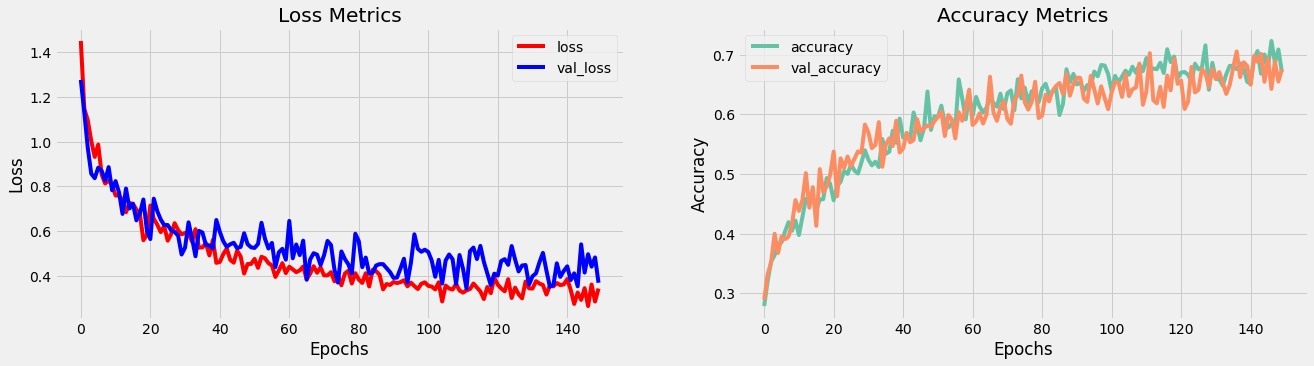

In [25]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Save Model

In [32]:
import pickle

pickle.dump(model, open('chatbot.pkl', 'wb'))

model.save('chatbot')

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


### Enumerates and prints the layers within the Encoder and Decoder components of the ChatBotTrainer model, providing a structured overview.

In [26]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


## Create Inference Model

### Builds an Inference model for the ChatBot, using the trained Encoder and Decoder models to predict responses.

In [27]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [28]:
chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        625408    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,151,232
Trainable params: 1,151,232

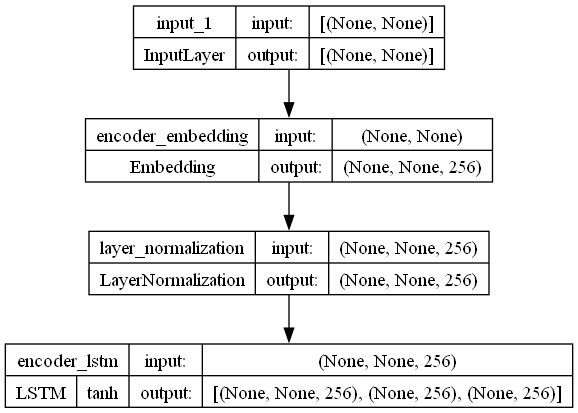

In [29]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

## Test ChatBot

In [30]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [31]:
print_conversation([
    'hi, how are you doing?	',
    'yes, I am doing great',
    'what is your name?',
    'are you a human or a bot?',
    'what is your favorite color?',
    'what is your favorite food?',
    'what is your favorite movie?',
])

You: hi, how are you doing?	
Bot: i'm going to change the light bulb. it burnt out. 
You: yes, I am doing great
Bot: i'm going to dinner with my family. 
You: what is your name?
Bot: the party says it will be good in a cemetery. 
You: are you a human or a bot?
Bot: yes. i just bought a cadillac. 
You: what is your favorite color?
Bot: someone. a ticket for the money. 
You: what is your favorite food?
Bot: i think i'm going to dream about anything. i'm really tired. 
You: what is your favorite movie?
Bot: i got a ticket downtown for $10. 
